# Introduction to Statistical Forecasting

In this tutorial we will be using S&P 500 Market Index to train, test and evaluate statistical models for forecasting. The tested models are:

* SARIMA - Seasonal Autoregressive Integrated Moving Average
* GARCH - Generalized AutoRegressive Conditional Heteroskedasticity 
* ETS - 
* Prophet - A package for forecasting developed by Facebook.

We get our S&P 500 Market Index data from Yahoo finance where we be using the respective package. 

The models effectively look back in time and try to _guess_ how the future could be based on the historical trend. In our model we will be focusing on the closing price of the S&P 500 Market Index data.

The blogpost is based on a series of published articles by [Towards AI](https://pub.towardsai.net/statistical-modeling-of-time-series-data-part-1-data-preparation-and-preprocessing-b52f26f6213c).



In [32]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_style("darkgrid")

import yfinance

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

## Data Preprocessing

In the following chapter we will load in and preprocess the data. For preprocessing we will handle the missing data and calculate additional features.

In [3]:
data_raw = yfinance.download(
    tickers = "^GSPC",
    start = "1994-01-07",
    end = "2021-12-01",
    interval = "1d"
)
data_raw.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1994-01-07,467.089996,470.260010,467.029999,469.899994,469.899994,324920000
1994-01-10,469.899994,475.269989,469.549988,475.269989,475.269989,319490000
1994-01-11,475.269989,475.279999,473.269989,474.130005,474.130005,305490000
1994-01-12,474.130005,475.059998,472.140015,474.170013,474.170013,310690000
1994-01-13,474.170013,474.170013,471.799988,472.470001,472.470001,277970000


In [4]:
df = pd.DataFrame(columns = ["close"])
df["close"] = data_raw["Close"]
df = df.asfreq("b")

There are certain dates where we have missing data in particular on non-trading days like weekends or bank holidays. We have to decide how those missing values are handled in the future processing. We can either drop, fill or interpolate the values. In our example we decide to forward fill the values.

In [5]:
fill_method = "ffill"

print(f"We have {df.close.isnull().sum()} days of missing data.")
print("\n--- Summary Statistics: ---")
print(df.describe())

df.close = df.close.fillna(method=fill_method)
print(f"\nAfter {fill_method} we have {df.close.isnull().sum()} days of missing data.")

We have 253 days of missing data.

--- Summary Statistics: ---
             close
count  7025.000000
mean   1560.430663
std     849.403739
min     438.920013
25%    1062.750000
50%    1300.250000
75%    1978.339966
max    4704.540039

After ffill we have 0 days of missing data.


In the following bit we will calculate Returns and Volatility to provide a better understanding of the general market trend. 

Here, describe Returns the precent change in stock price over a given time period. In this case the time period is one day. The Volatitility of the Market Index referes to the fluctuations in returns. 

In [6]:
df["returns"] = df["close"].pct_change(1).mul(100)
df["volatility"] = df["returns"].abs()

df.head()

,close,returns,volatility
Date,,,
1994-01-07,469.899994,NaN,NaN
1994-01-10,475.269989,1.142795,1.142795
1994-01-11,474.130005,-0.239860,0.239860
1994-01-12,474.170013,0.008438,0.008438
1994-01-13,472.470001,-0.358524,0.358524


# Data Exploratory and Analysis

In this part we will visualize and explore the data to understand any underlying trends, patterns and characteristiics that can help later model/ forecast the data. 

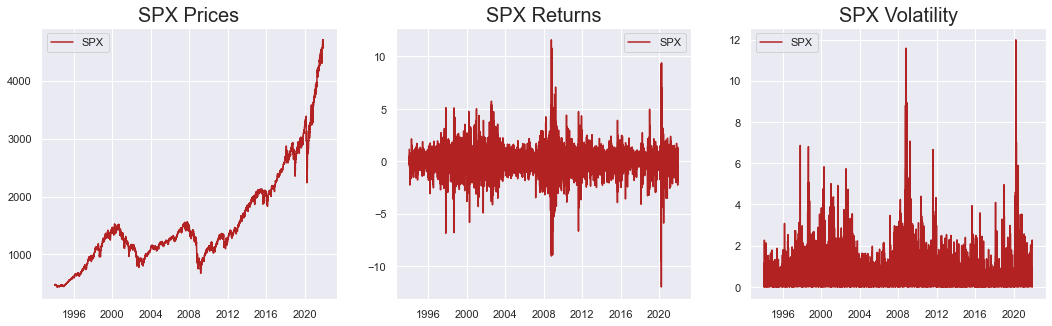

In [7]:
fix, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(18,5))

# General time series plot
ax[0].plot(df["close"], color = "firebrick", label = "SPX")
ax[0].set_title("SPX Prices", size = 20)
ax[0].legend()

ax[1].plot(df["returns"], color = "firebrick", label = "SPX")
ax[1].set_title("SPX Returns", size = 20)
ax[1].legend()

ax[2].plot(df["volatility"], color = "firebrick", label = "SPX")
ax[2].set_title("SPX Volatility", size = 20)
ax[2].legend()

plt.show()

Next we will split the data in training and testing. Like most real world data problems we won't have access to the future predictions. Which means we have to train the model on the training data (building the model) and then test it on the testing data (evaluating the model). It would actually be better tho use Cross-Validation to improve the model generalization, but for simplicity we will just to a simply train, test slit. We will split the data into 80% training and 20% testing.

In [8]:
df_train = df.loc[:"2020-12-31"].copy() # To avoid issue with view/copy with pandas.
df_test = df.loc["2021-01-01":].copy()

print(f"The shape of the training data is: {df_train.shape}. The shape of the testing data is: {df_test.shape}")

The shape of the training data is: (7040, 3). The shape of the testing data is: (238, 3)


In the following we will do all exploring, analysing and model building on the training data set. First we will plot the time series as boxplot aggregated by year for all three features. Therefore we add another column named "year" to the training data set.

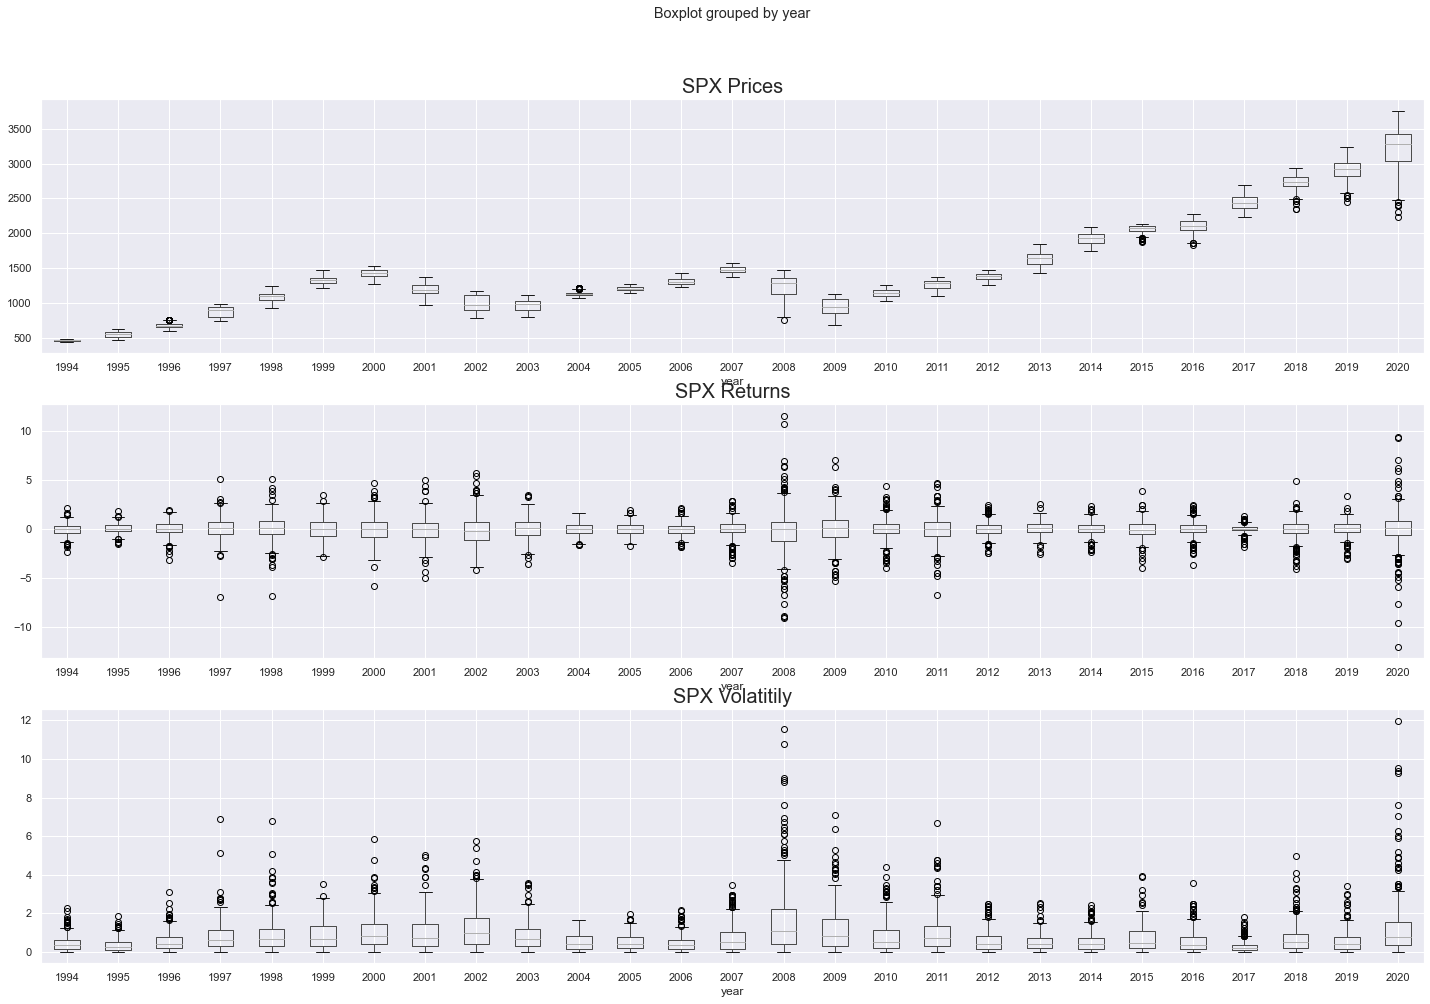

In [9]:
df_train.loc[:, "year"] = df_train.index.year

fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (24,16))

df_train.boxplot(by = "year", column = ["close"], ax = ax[0])
ax[0].set_title("SPX Prices", size = 20)

df_train.boxplot(by = "year", column = ["returns"], ax = ax[1])
ax[1].set_title("SPX Returns", size = 20)

df_train.boxplot(by = "year", column = "volatility", ax = ax[2])
ax[2].set_title("SPX Volatitily", size = 20)

plt.show()

Another good tool to gain a better understanding of the data for modelling is using Density Curves and Histograms. Some of the key takeaways from the plots are:

* Prices look vaguely normal distributed with spikes and a long tailing edge.
* Returns look normally distributed with 0 mean.
* Volatility looks heavily right-skewed with a long right tail.

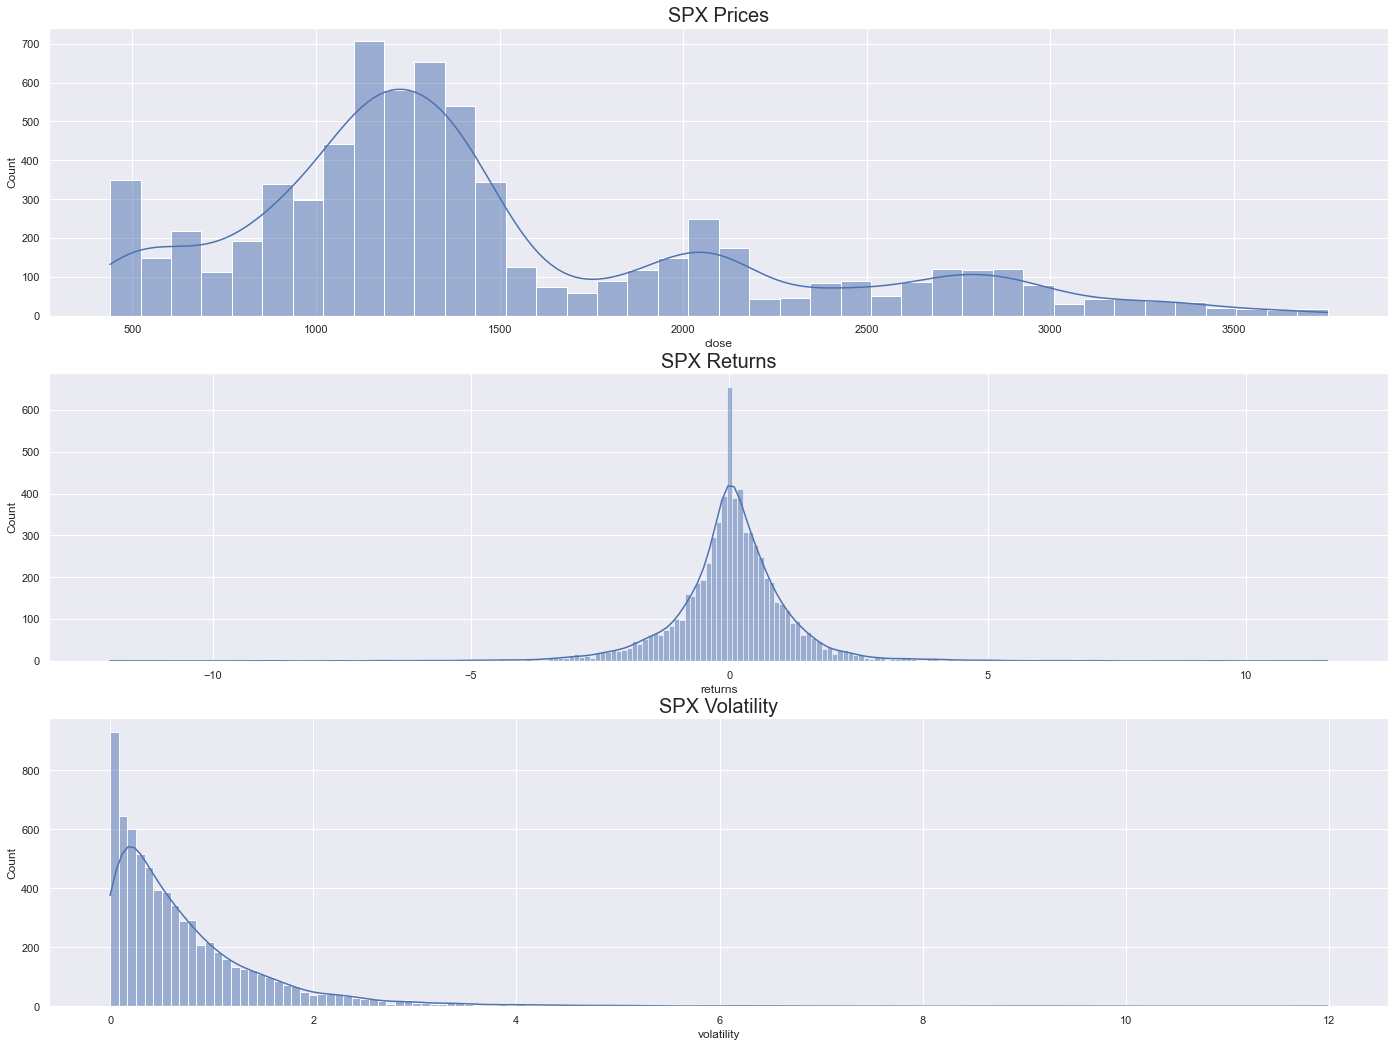

In [10]:
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (24, 18))

sns.histplot(df_train["close"], ax = ax[0], kde=True)
sns.histplot(df_train["returns"], ax = ax[1], kde=True)
sns.histplot(df_train["volatility"], ax = ax[2], kde=True)

ax[0].set_title("SPX Prices", size = 20)
ax[1].set_title("SPX Returns", size = 20)
ax[2].set_title("SPX Volatility", size = 20)

plt.show()

Another common characteristic in time series data is the composition of trend, seasonality and noise. To gain a better understanding we will decomposition the data set using the statsmodel library. There two types of decomposition, additive and multiplicative. In additive decompostion the time series is represented as a sum of trend, seasonality and noise. In the multiplicative decomposition the series is represented as the product of these three. 

We will first plot the whole decomposed time series and then narrow in on the seasonal trend.

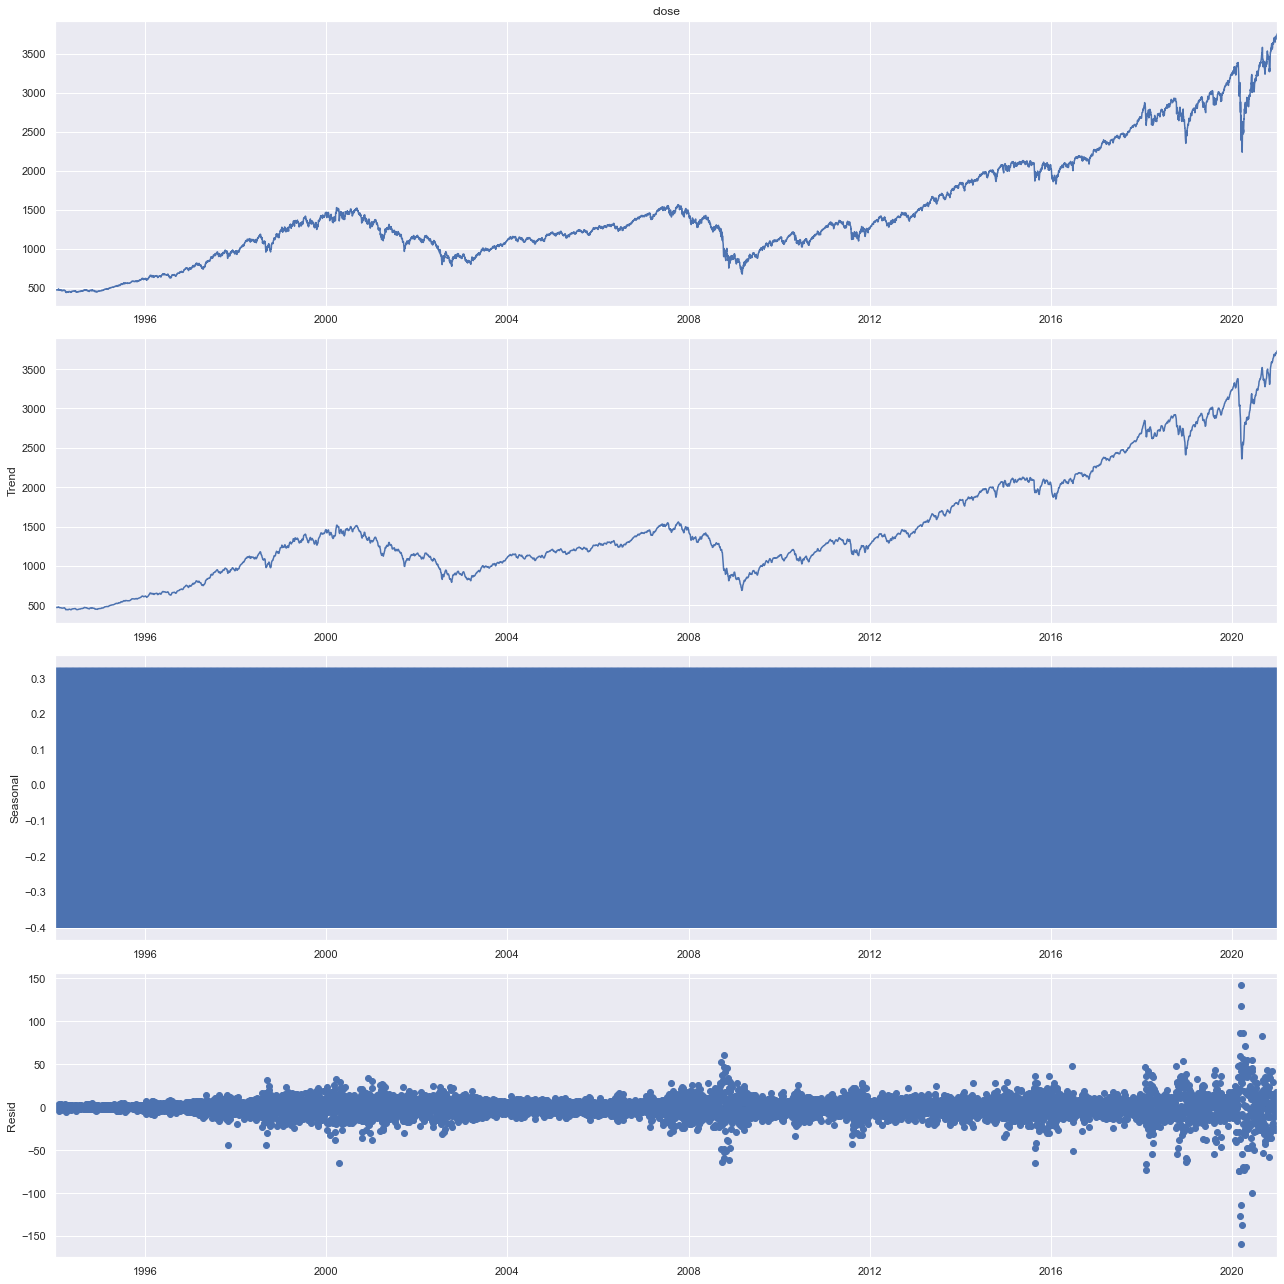

In [11]:
df_train_decomposed = seasonal_decompose(df_train["close"], model="addititive")


plt.rcParams["figure.figsize"] = 18, 18
df_train_decomposed.plot()
plt.show()

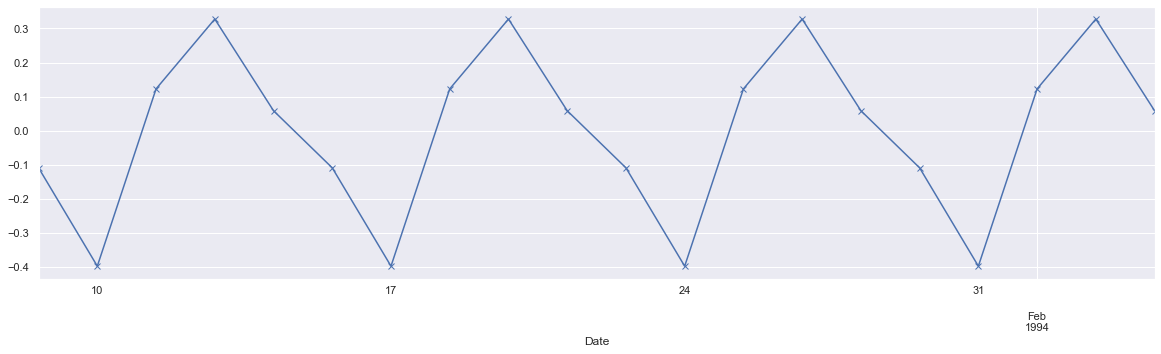

In [12]:
plt.rcParams["figure.figsize"] = 20, 5
df_train_decomposed.seasonal[:20].plot(marker = "x")
plt.show()

Next we will apply smoothing to remove some of the erratic fluctuations and spikes from the time series. This is done by calculating the moving average over a period of time. This period can be defined either at the end of the period as n-1 past lags or at the center of the period about (n-1)/2 past lags. Below we will apply the approach at the end of the period.

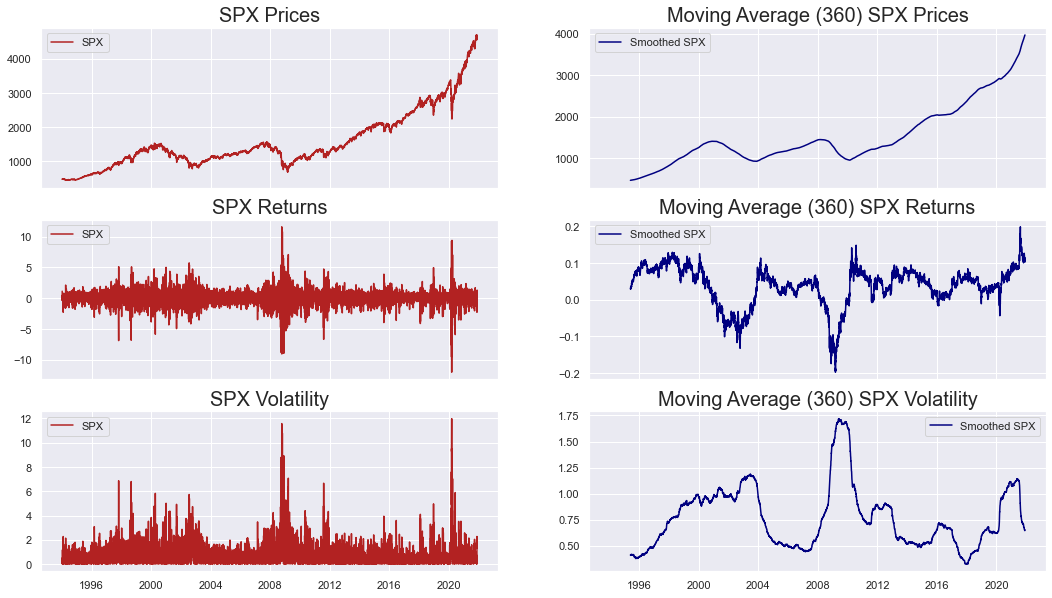

In [13]:
fig, ax = plt.subplots(nrows = 3, ncols = 2, sharex=True, figsize=(18,10))

ax[0, 0].plot(df["close"], color = "firebrick", label = "SPX")
ax[0, 0].set_title("SPX Prices", size = 20)
ax[0, 0].legend()

ax[1, 0].plot(df["returns"][1:], color = "firebrick", label = "SPX")
ax[1, 0].set_title("SPX Returns", size = 20)
ax[1, 0].legend()

ax[2, 0].plot(df["volatility"][1:], color = "firebrick", label = "SPX")
ax[2, 0].set_title("SPX Volatility", size = 20)
ax[2, 0].legend()

ax[0, 1].plot(df["close"].rolling(window=360).mean(), color = "navy", label = "Smoothed SPX")
ax[0, 1].set_title("Moving Average (360) SPX Prices", size = 20)
ax[0, 1].legend()

ax[1, 1].plot(df["returns"].rolling(window=360).mean(), color = "navy", label = "Smoothed SPX")
ax[1, 1].set_title("Moving Average (360) SPX Returns", size = 20)
ax[1, 1].legend()

ax[2, 1].plot(df["volatility"].rolling(window=360).mean(), color = "navy", label = "Smoothed SPX")
ax[2, 1].set_title("Moving Average (360) SPX Volatility", size = 20)
ax[2, 1].legend()

plt.show()

Further, it is important to understand how dependent the time series is with it's past versions (or lagged versions). The dependency can be calculated via correlation between the two series.Two types of correlation are frequently used to understand the dependency of time series data. These are Auto-Correlation Function (ACF) and Patrial Auto-Correlation Function.

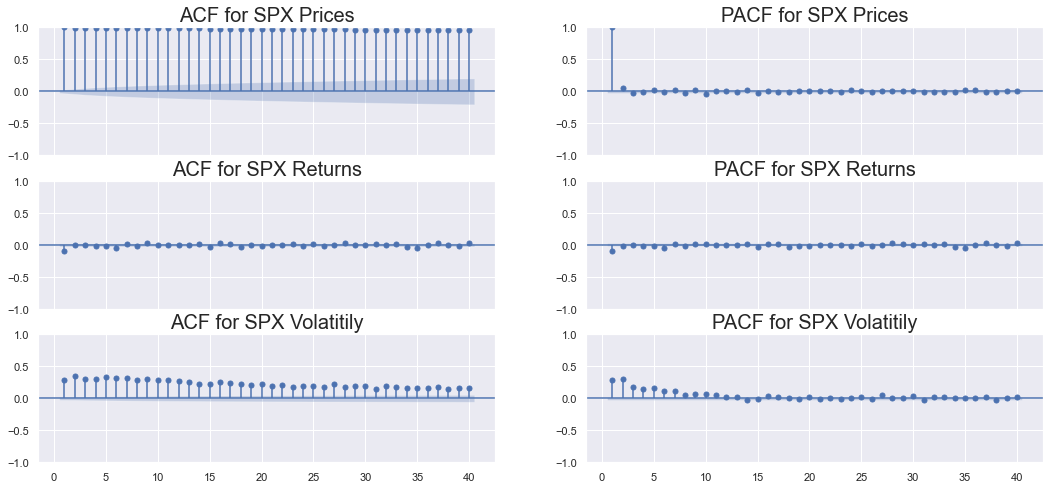

In [14]:
fig, ax = plt.subplots(nrows=3, ncols=2, sharex=True, figsize=(18,8))

sgt.plot_acf(df_train["close"], zero=False, lags=40, ax = ax[0,0])
sgt.plot_acf(df_train["returns"][1:], zero=False, lags=40, ax=ax[1,0])
sgt.plot_acf(df_train["volatility"][1:], zero=False, lags=40, ax=ax[2,0])

ax[0,0].set_title("ACF for SPX Prices", size=20)
ax[1,0].set_title("ACF for SPX Returns", size=20)
ax[2,0].set_title("ACF for SPX Volatitily", size=20)

sgt.plot_pacf(df_train["close"], zero=False, lags=40, method='ywm', ax=ax[0,1])
sgt.plot_pacf(df_train["returns"][1:], zero=False, lags=40, method='ywm', ax=ax[1,1])
sgt.plot_pacf(df_train["volatility"][1:], zero=False, lags=40, method='yw', ax=ax[2,1])

ax[0,1].set_title("PACF for SPX Prices", size=20)
ax[1,1].set_title("PACF for SPX Returns", size=20)
ax[2,1].set_title("PACF for SPX Volatitily", size=20)

plt.show()

Next we check for stationarity. Here, characteristics like mean, variance etc. are used to check on the time series data. If the data is stationary we can make pretty good assumptions on the distribution of the underlying data. However, if the data is non-stationary we can't be sure what the underlying distribtion will not change in the future. There are different ways to test for stationary. First there is visaul inspection when we plot the series and inspect wheter there are any obvious trends or seasonal cycles. Secondly, we can plot summary statistics like mean and variance over a time period. Lastly, we conduct a statistic test (a more quantitative approach). A common test is the Augmented-Dickey Fuller (AFD). 

In the below code chunks we will work through the three different methods in the presented order.

Indication's of ADF tests:
* Returns and Volatitily are both stationary.
* Close Price is non-stationary.

------- VISUAL INSPECTION -------


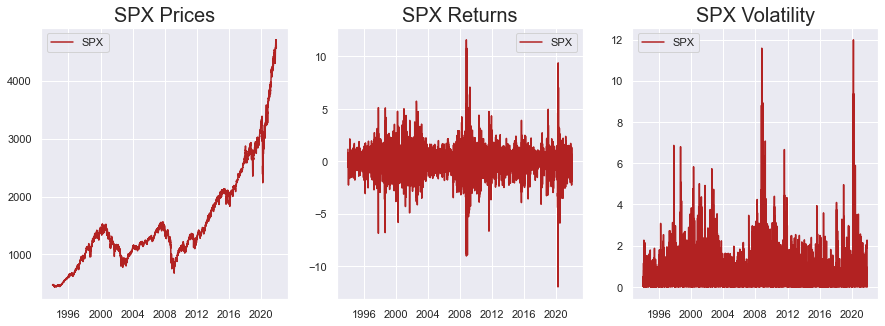

In [15]:
print("------- VISUAL INSPECTION -------")

fix, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(15,5))

# General time series plot
ax[0].plot(df["close"], color = "firebrick", label = "SPX")
ax[0].set_title("SPX Prices", size = 20)
ax[0].legend()

ax[1].plot(df["returns"], color = "firebrick", label = "SPX")
ax[1].set_title("SPX Returns", size = 20)
ax[1].legend()

ax[2].plot(df["volatility"], color = "firebrick", label = "SPX")
ax[2].set_title("SPX Volatility", size = 20)
ax[2].legend()

plt.show()

------- PLOTTING SUMMARY STATISTICS -------


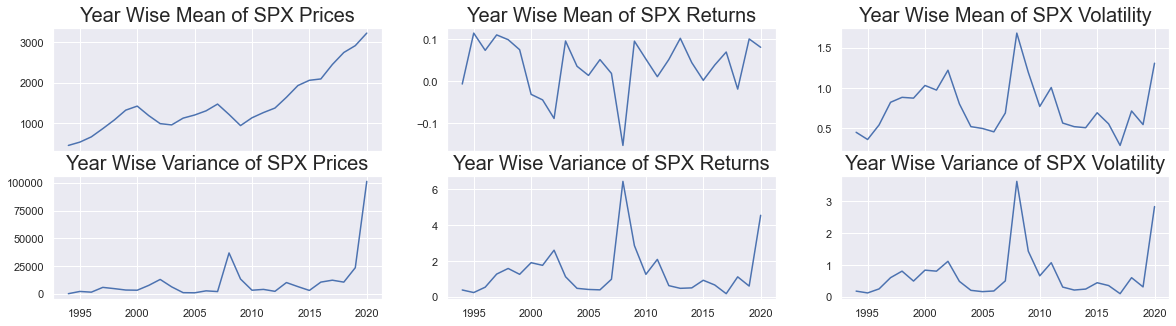

In [16]:
print("------- PLOTTING SUMMARY STATISTICS -------")

df_train_mean = df_train.groupby(by=df_train.index.year).mean()
df_train_var = df_train.groupby(by=df_train.index.year).var()

fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True)

ax[0,0].plot(df_train_mean["close"])
ax[0,1].plot(df_train_mean["returns"])
ax[0,2].plot(df_train_mean["volatility"])

ax[0,0].set_title("Year Wise Mean of SPX Prices", size=20)
ax[0,1].set_title("Year Wise Mean of SPX Returns", size=20)
ax[0,2].set_title("Year Wise Mean of SPX Volatility", size=20)

ax[1,0].plot(df_train_var["close"])
ax[1,1].plot(df_train_var["returns"])
ax[1,2].plot(df_train_var["volatility"])

ax[1,0].set_title("Year Wise Variance of SPX Prices", size=20)
ax[1,1].set_title("Year Wise Variance of SPX Returns", size=20)
ax[1,2].set_title("Year Wise Variance of SPX Volatility", size=20)

plt.show()

In [17]:
print("------- AFD STATISTICAL TEST -------")

adfuller(df_train["close"])

------- AFD STATISTICAL TEST -------


(1.597779505591753,
 0.9978508987817833,
 35,
 7004,
 {'1%': -3.4312839946101836,
  '5%': -2.861952750617921,
  '10%': -2.56698970317769},
 60418.42269224073)

# Modelling

In the following bit we will apply the three different modelling techniques. 

## SARIMA (non-seasonal)

The model is a correlation of three components. 

* Auto-rgressive Component (AR): This is used to capture the dependence of current observation with past observation. The controlling paramterer for this is denoted as p. The q also describes the number of significant lags int the PACF plot of the time series.
* Integrated (I): It discribes the differencing that is carriet out till the series is stationary. The parameter of the model controlling it is d. The d needs to be defferenced x number of times to remove trend and stationarity.
* Moving average (MA): This is used to capture the effect of past residuals on the value of the current observation. The controlling parameter is denoted as q. The q describes the number of significant lags in the ACF plot. 

First we will establish our parameters. For that we will plot again the ACF and PACF of the returns. 

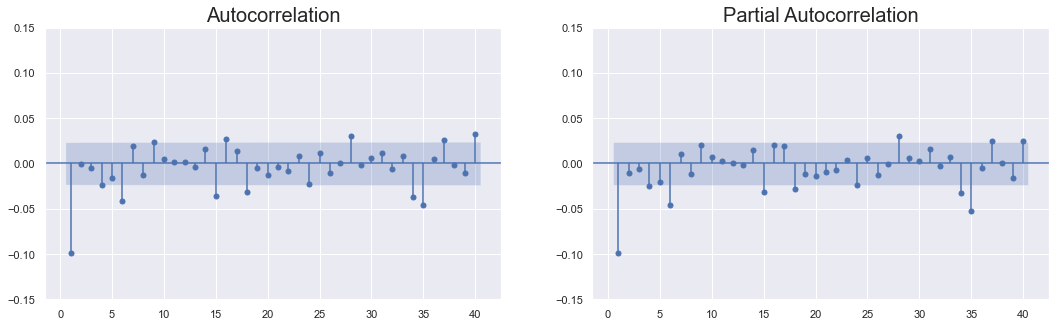

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(18,5))


sgt.plot_acf(df_train["returns"][1:], zero=False, lags=40, ax=ax[0])
ax[0].set_title("Autocorrelation", size=20)
ax[0].set_ylim(-0.15, 0.15)

sgt.plot_pacf(df_train["returns"][1:], zero=False, lags=40, method='ywm', ax=ax[1])
ax[1].set_title("Partial Autocorrelation", size=20)
ax[1].set_ylim(-0.15, 0.15)

plt.show()

We can identify that mainly the first point is significant. From those plots we identify that a good starting point for ARIMA is p = 1 and q = 1.Since the previous test already had shown that the series is stationary we can set d = 0.

This would reflect a ARIMA(101) model.

Models with higher log likelihood or low IC values are better. Additionally we need to make sure that the residuals or erros don't have have an underlying an underlying trend. We can confirm this by plotting the ACF and PACF for the resiudals.

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 7039
Model:               SARIMAX(1, 0, 1)   Log Likelihood              -11072.169
Date:                Fri, 10 Dec 2021   AIC                          22150.338
Time:                        14:00:11   BIC                          22170.916
Sample:                    01-10-1994   HQIC                         22157.427
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0142      0.048      0.294      0.769      -0.080       0.109
ma.L1         -0.1127      0.049     -2.322      0.020      -0.208      -0.018
sigma2         1.3608      0.009    144.313      0.0

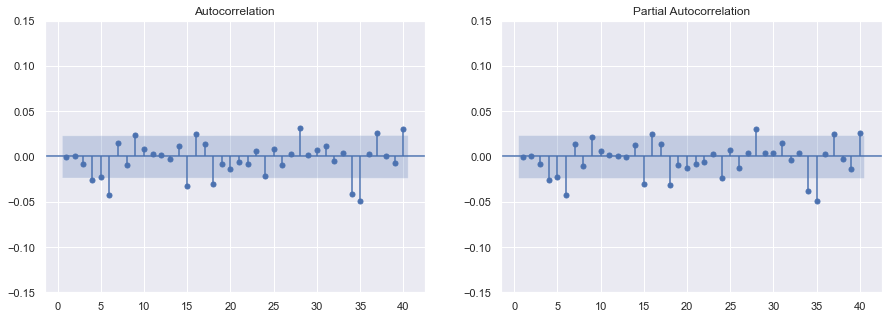

In [33]:
nseas_model = SARIMAX(df_train["returns"][1:], order = (1, 0, 1))
nseas_model_results = nseas_model.fit()

print(nseas_model_results.summary())

print("--------------------------------------------")

# ACF and PACF for residuals of ARIMA(1, 0, 1)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sgt.plot_acf(nseas_model_results.resid[1:], zero = False, lags = 40, ax = ax[0])
sgt.plot_pacf(nseas_model_results.resid[1:], zero = False, lags = 40, method="ywm", ax = ax[1])
ax[0].set_ylim(-0.15, 0.15)
ax[1].set_ylim(-0.15, 0.15)
plt.show()

## SARIMA (seasonal)

We have already created a non-seasonal SARIMA model. However, to include the seasonal impact we can use SARIMA(p,d,q)(P,D,Q,m) where,
* p, d, q are the same as in the normal ARIMA model.
* m describes the seasonal periods or the number of periods in a series after whcih a seasonal pattern is repeated. In literature this is often denoted as s.
* P or the seasonal AR component. Unlike the p, the past lags are separated from the current lag by multiples of m lags. 
* D or the seasonal I component. This is the number of times seasonal differences need to be calculated in order to make the series stationary. Unlike d, where we differenced after the first lagged series, the difference is done between the mth lagged series.
* Q or the seasonal MA component. This parameter captures the effect of past residuals but unlike q, past lags are separated from the current lag by multiples of m lags.

We previously already plotted the ACF and PACF plot. So we can set the p = 1 and the q = 1. Additionally we already know that d = 0. The observations are observed on business days (5 days a week), hence m = 5. Futrhter we set P = 1, D = 0 and Q = 1 since stationary and mth values are significant. 

                                     SARIMAX Results                                     
Dep. Variable:                           returns   No. Observations:                 7039
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 5)   Log Likelihood              -11069.718
Date:                           Fri, 10 Dec 2021   AIC                          22149.436
Time:                                   14:00:16   BIC                          22183.732
Sample:                               01-10-1994   HQIC                         22161.251
                                    - 12-31-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0092      0.049      0.188      0.851      -0.086       0.104
ma.L1         -0.1084      0.049     -2.214

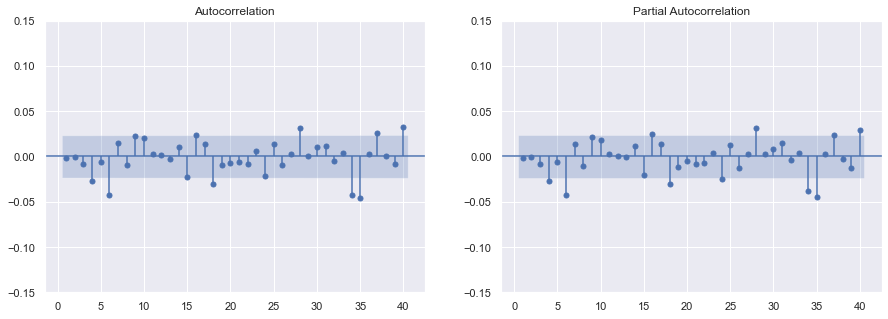

In [34]:
seas_model = SARIMAX(df_train["returns"][1:], order = (1, 0, 1), seasonal_order=(1, 0, 1, 5))
seas_model_results = seas_model.fit()

print(seas_model_results.summary())

print("--------------------------------------------")

# ACF and PACF for residuals of ARIMA(1, 0, 1)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sgt.plot_acf(seas_model_results.resid[1:], zero = False, lags = 40, ax = ax[0])
sgt.plot_pacf(seas_model_results.resid[1:], zero = False, lags = 40, method="ywm", ax = ax[1])
ax[0].set_ylim(-0.15, 0.15)
ax[1].set_ylim(-0.15, 0.15)
plt.show()

## Comparison of seasonal and non-seasonal model

To evaluate model performance we will use the root mean squarred error of the models. Additionally we will use the confidence intervalls to create a forecast plot. However, to get the model performance we will have to create a forecast object. 

----------- Model performance is: -----------
    ARIMA: 0.789
    SARIMA: 0.789
---------------------------------------------


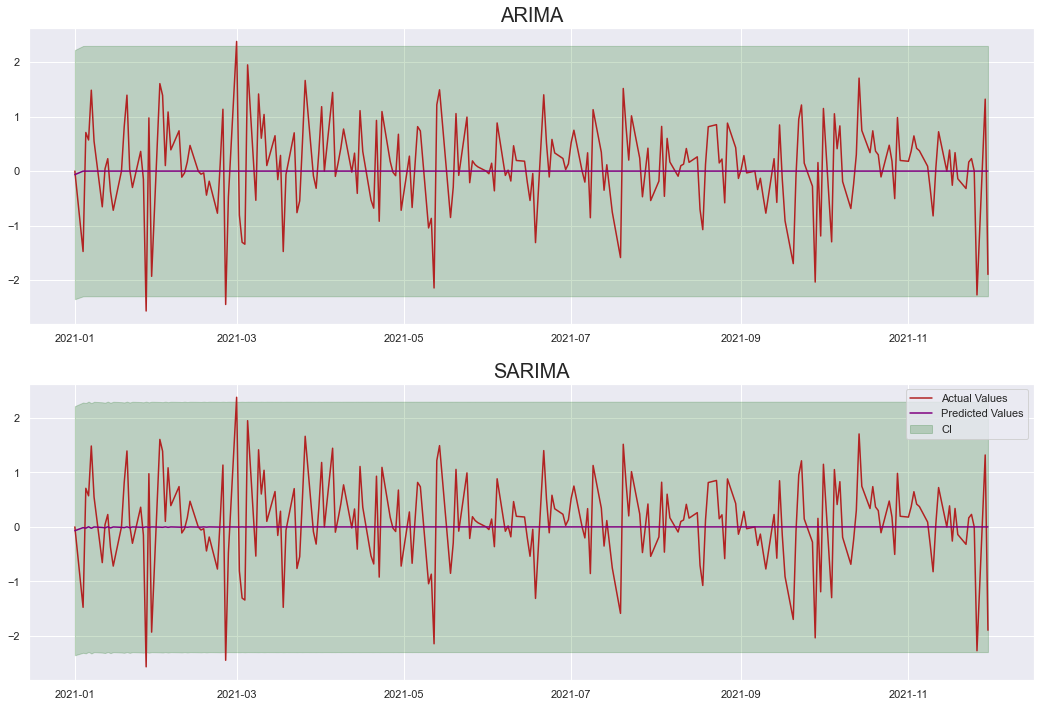

In [55]:
nseas_pred = nseas_model_results.predict(start=df_test.index[0], end=df_test.index[-1])
seas_pred = seas_model_results.predict(start=df_test.index[0], end=df_test.index[-1])

# Get quality metrics
arima_rmse = np.sqrt(
    mean_squared_error(y_true = df_test["returns"].values, y_pred = nseas_pred.values)
)

sarima_rmse = np.sqrt(
    mean_squared_error(y_true = df_test["returns"].values, y_pred = seas_pred.values)
)

print(f"----------- Model performance is: -----------")
print(f"    ARIMA: {round(arima_rmse,3)}")
print(f"    SARIMA: {round(sarima_rmse,3)}")
print("---------------------------------------------")

nseas_forecast = nseas_model_results.get_forecast(len(df_test.index))
df_nseas_forecast = nseas_forecast.conf_int(alpha = 0.05)
df_nseas_forecast["predictions"] = nseas_pred

seas_forecast = seas_model_results.get_forecast(len(df_test.index))
df_seas_forecast = seas_forecast.conf_int(alpha = 0.05)
df_seas_forecast["predictions"] = seas_pred

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(18, 12))

ax[0].plot(df_test["returns"], color="firebrick", label="Actual Values")
ax[0].plot(df_nseas_forecast["predictions"], color="purple", label="Predicted Values")
ax[0].fill_between(df_nseas_forecast.index, df_nseas_forecast["lower returns"], df_nseas_forecast["upper returns"], color="darkgreen", alpha=0.2, label="CI")
ax[0].set_title("ARIMA", size=20)

ax[1].plot(df_test["returns"], color="firebrick", label="Actual Values")
ax[1].plot(df_seas_forecast["predictions"], color="purple", label="Predicted Values")
ax[1].fill_between(df_seas_forecast.index, df_seas_forecast["lower returns"], df_seas_forecast["upper returns"], color="darkgreen", alpha=0.2, label="CI")
ax[1].set_title("SARIMA", size=20)

plt.legend()
plt.show()
